KNN

Extracting files...
Starting Vectorization and KNN analysis...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters without SMOTE: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best F1 Score without SMOTE: 0.8827106549133752
Starting KNN analysis with SMOTE for 3-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [169  31]
Validation class distribution: [85 16]
[[65 20]
 [ 7  9]]


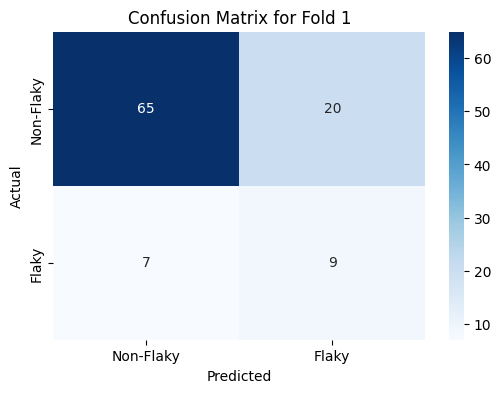

Fold 1: Accuracy=0.7326732673267327, Precision=0.8089270133909944, Recall=0.7326732673267327, F1=0.7602194614365897, MCC=0.26407379676423837
Training class distribution: [170  31]
Validation class distribution: [84 16]
[[73 11]
 [ 5 11]]


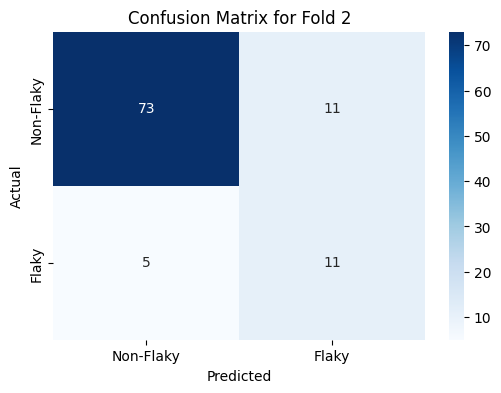

Fold 2: Accuracy=0.84, Precision=0.8661538461538462, Recall=0.84, F1=0.8496686159844055, MCC=0.49254205921695676
Training class distribution: [169  32]
Validation class distribution: [85 15]
[[73 12]
 [ 6  9]]


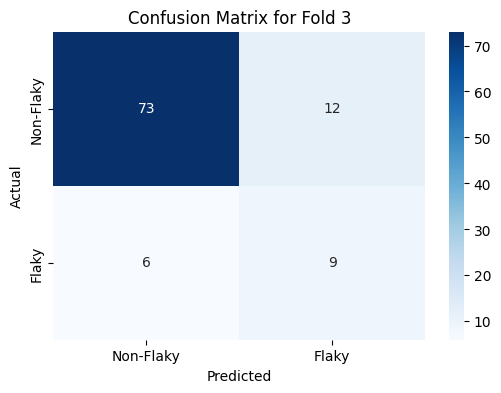

Fold 3: Accuracy=0.82, Precision=0.8497287522603979, Recall=0.82, F1=0.8317073170731707, MCC=0.40223289124336936
Average Accuracy: 0.7975577557755775
Average Precision: 0.8416032039350795
Average Recall: 0.7975577557755775
Average F1: 0.8138651314980553
Average MCC: 0.38628291574152146
KNN analysis completed for 3-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger-knn-results-3-folds.csv
Starting KNN analysis with SMOTE for 5-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [203  37]
Validation class distribution: [51 10]
[[39 12]
 [ 4  6]]


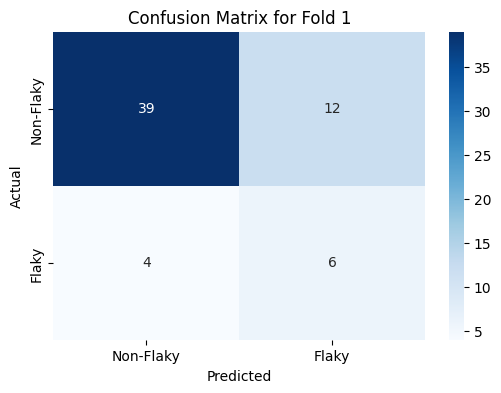

Fold 1: Accuracy=0.7377049180327869, Precision=0.812936840767569, Recall=0.7377049180327869, F1=0.7640141511784343, MCC=0.2960447582039059
Training class distribution: [204  37]
Validation class distribution: [50 10]
[[38 12]
 [ 3  7]]


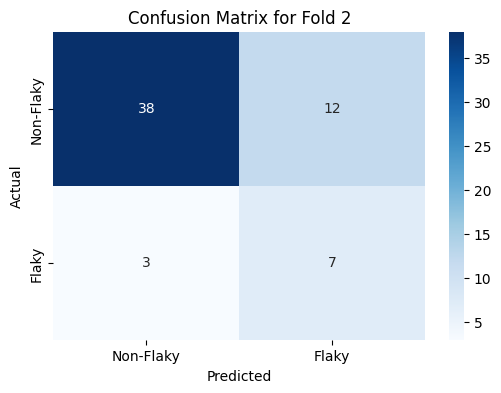

Fold 2: Accuracy=0.75, Precision=0.8337612323491655, Recall=0.75, F1=0.7764304660856385, MCC=0.36853106738124597
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[45  6]
 [ 4  5]]


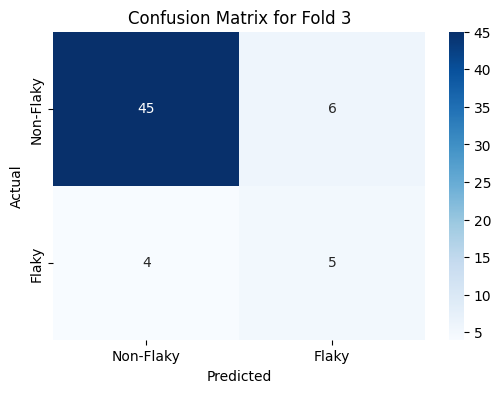

Fold 3: Accuracy=0.8333333333333334, Precision=0.8487940630797774, Recall=0.8333333333333334, F1=0.84, MCC=0.4041060310241455
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[41 10]
 [ 4  5]]


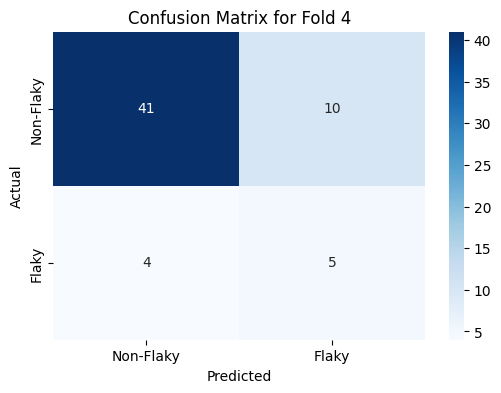

Fold 4: Accuracy=0.7666666666666667, Precision=0.8244444444444444, Recall=0.7666666666666667, F1=0.7885416666666667, MCC=0.29643243059996255
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[47  4]
 [ 1  8]]


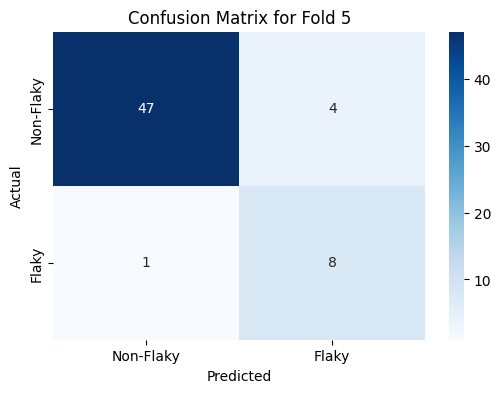

Fold 5: Accuracy=0.9166666666666666, Precision=0.9322916666666666, Recall=0.9166666666666666, F1=0.9213564213564213, MCC=0.7234780434144716
Average Accuracy: 0.8008743169398909
Average Precision: 0.8504456494615248
Average Recall: 0.8008743169398909
Average F1: 0.8180685410574322
Average MCC: 0.41771846612474633
KNN analysis completed for 5-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger-knn-results-5-folds.csv
Final Average Metrics for 3-fold:
Accuracy: 0.7975577557755775
Precision: 0.8416032039350795
Recall: 0.7975577557755775
F1 Score: 0.8138651314980553
MCC: 0.38628291574152146
Final Average Metrics for 5-fold:
Accuracy: 0.8008743169398909
Precision: 0.8504456494615248
Recall: 0.8008743169398909
F1 Score: 0.8180685410574322
MCC: 0.41771846612474633


In [15]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty or invalid file skipped: {file_path}")

    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")

    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Step 1: Run GridSearchCV without SMOTE to find the best parameters

def find_best_params_without_smote(Z, dataLabelsList, n_splits):
    knn = KNeighborsClassifier()

    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
        'metric': ['cosine', 'euclidean'],
        'weights': ['uniform', 'distance']
    }

    # Custom scorer for MCC
    def mcc_scorer(y_true, y_pred):
        return matthews_corrcoef(y_true, y_pred)

    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=1),
        'recall': make_scorer(recall_score, average='weighted', zero_division=1),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=1),
        'mcc': make_scorer(mcc_scorer)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(knn, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV on the original data without SMOTE
    grid_search.fit(Z, dataLabelsList)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters without SMOTE: {best_params}")
    print(f"Best F1 Score without SMOTE: {best_score}")

    return best_params

###############################################################################
# Step 2: Apply SMOTE only to the training data and run GridSearchCV with the best parameters

def flastKNNWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label, best_params):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")

    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_list, precision_list, recall_list, f1_list, mcc_list = [], [], [], [], []

    # Apply SMOTE and KNN with best parameters for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z, dataLabelsList), start=1):
        X_train, X_val = Z[train_idx], Z[val_idx]
        y_train, y_val = dataLabelsList[train_idx], dataLabelsList[val_idx]

        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        smote = SMOTE(random_state=42)
        # Apply SMOTE to the training data only
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Define the KNN model with best parameters
        knn = KNeighborsClassifier(
            n_neighbors=best_params['n_neighbors'],
            metric=best_params['metric'],
            weights=best_params['weights']
        )

        # Train the model and make predictions on the validation set
        knn.fit(X_resampled, y_resampled)
        y_pred = knn.predict(X_val)

        # Compute metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=1)
        mcc = matthews_corrcoef(y_val, y_pred)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)

        # Plot confusion matrix for the current fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)

        print(f"Fold {fold_idx}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1={f1}, MCC={mcc}")

    # Calculate average scores over all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    avg_mcc = np.mean(mcc_list)

    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1: {avg_f1}")
    print(f"Average MCC: {avg_mcc}")

    # Save the results to a CSV file
    outFile = os.path.join(outDir, f"{combination_label}-knn-results-{n_splits}-folds.csv")
    with open(outFile, "w") as f:
        f.write("Fold,Accuracy,Precision,Recall,F1,MCC\n")
        for idx, (acc, prec, rec, f1_score_val, mcc_val) in enumerate(zip(accuracy_list, precision_list, recall_list, f1_list, mcc_list), start=1):
            f.write(f"{idx},{acc},{prec},{rec},{f1_score_val},{mcc_val}\n")
        # Write the average metrics as the last row
        f.write(f"Average,{avg_accuracy},{avg_precision},{avg_recall},{avg_f1},{avg_mcc}\n")

    print(f"KNN analysis completed for {n_splits}-folds with SMOTE. Results saved to: {outFile}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_mcc

###############################################################################
# Main Function to Run Both 3-Fold and 5-Fold SMOTE

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "cleaned_flaky_files.zip"
    largerNonFlakyZip = "all_nonflaky_files.zip"

    outDirLarger = "smote2-results/larger_nonflaky"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote2-extracted/larger_nonflaky/"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Step 1: Extract zip files into correct directories
    print("Extracting files...")
    flakyDir = os.path.join(extractDirLarger, 'flaky')
    nonFlakyDir = os.path.join(extractDirLarger, 'nonFlaky')

    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(largerNonFlakyZip, nonFlakyDir)

    # Step 1: Vectorization
    print("Starting Vectorization and KNN analysis...")
    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    if len(dataPoints) == 0:
        raise ValueError("No documents found for vectorization. Please check the input files or directories.")

    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))

    # Step 1: Run GridSearchCV without SMOTE to find best parameters
    best_params = find_best_params_without_smote(Z, dataLabelsList, n_splits=5)

    # Step 2: Apply SMOTE for both 3-Fold and 5-Fold Cross-Validation

    print("Starting KNN analysis with SMOTE for 3-fold cross-validation...")
    avg_accuracy_3folds, avg_precision_3folds, avg_recall_3folds, avg_f1_3folds, avg_mcc_3folds = flastKNNWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger", best_params)

    print("Starting KNN analysis with SMOTE for 5-fold cross-validation...")
    avg_accuracy_5folds, avg_precision_5folds, avg_recall_5folds, avg_f1_5folds, avg_mcc_5folds = flastKNNWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger", best_params)

    print(f"Final Average Metrics for 3-fold:\nAccuracy: {avg_accuracy_3folds}\nPrecision: {avg_precision_3folds}\nRecall: {avg_recall_3folds}\nF1 Score: {avg_f1_3folds}\nMCC: {avg_mcc_3folds}")
    print(f"Final Average Metrics for 5-fold:\nAccuracy: {avg_accuracy_5folds}\nPrecision: {avg_precision_5folds}\nRecall: {avg_recall_5folds}\nF1 Score: {avg_f1_5folds}\nMCC: {avg_mcc_5folds}")


SVM

Extracting files...
Starting Vectorization and SVM analysis...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters without SMOTE: {'C': 0.1, 'kernel': 'linear'}
Best F1 Score without SMOTE: 0.9005527483275226
Starting SVM analysis with SMOTE for 3-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [169  31]
Validation class distribution: [85 16]
[[83  2]
 [ 8  8]]


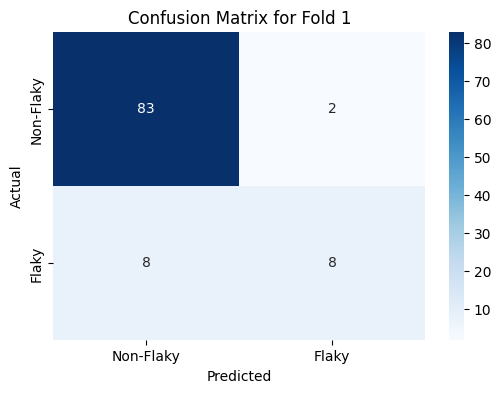

Fold 1: Accuracy=0.900990099009901, Precision=0.8943314111630943, Recall=0.900990099009901, F1=0.8912535484317663, MCC=0.5824851468902619
Training class distribution: [170  31]
Validation class distribution: [84 16]
[[83  1]
 [ 7  9]]


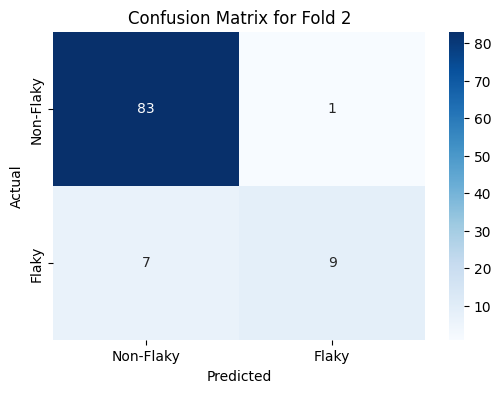

Fold 2: Accuracy=0.92, Precision=0.9186666666666667, Recall=0.92, F1=0.9121485411140583, MCC=0.6728384948943098
Training class distribution: [169  32]
Validation class distribution: [85 15]
[[81  4]
 [ 8  7]]


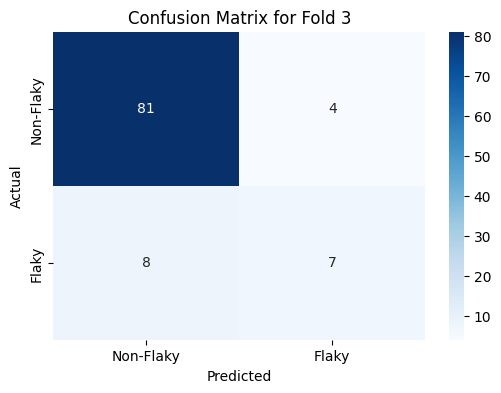

Fold 3: Accuracy=0.88, Precision=0.869050051072523, Recall=0.88, F1=0.8721485411140584, MCC=0.4788586576139561
Average Accuracy: 0.9003300330033004
Average Precision: 0.8940160429674281
Average Recall: 0.9003300330033004
Average F1: 0.8918502102199609
Average MCC: 0.578060766466176
SVM analysis completed for 3-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_svm-svm-results-3-folds.csv
Starting SVM analysis with SMOTE for 5-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [203  37]
Validation class distribution: [51 10]
[[51  0]
 [ 3  7]]


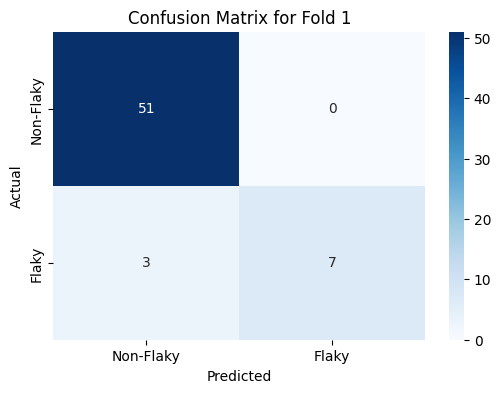

Fold 1: Accuracy=0.9508196721311475, Precision=0.953551912568306, Recall=0.9508196721311475, F1=0.9471828075492492, MCC=0.8130873945100312
Training class distribution: [204  37]
Validation class distribution: [50 10]
[[47  3]
 [ 2  8]]


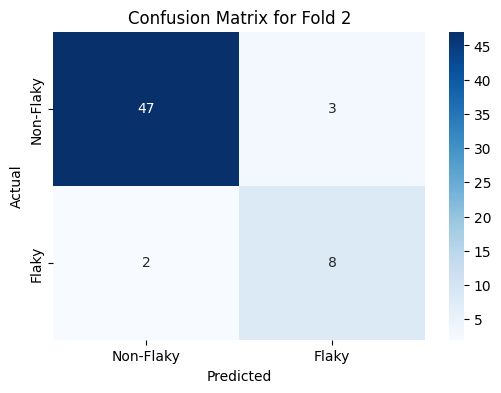

Fold 2: Accuracy=0.9166666666666666, Precision=0.9205318491032776, Recall=0.9166666666666666, F1=0.9182299182299183, MCC=0.7127255688897131
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[49  2]
 [ 6  3]]


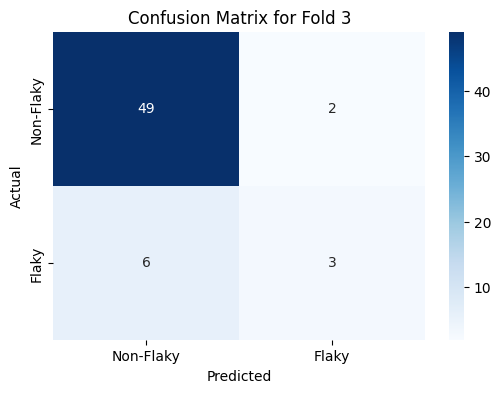

Fold 3: Accuracy=0.8666666666666667, Precision=0.8472727272727273, Recall=0.8666666666666667, F1=0.8501347708894879, MCC=0.3799802978286742
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[48  3]
 [ 4  5]]


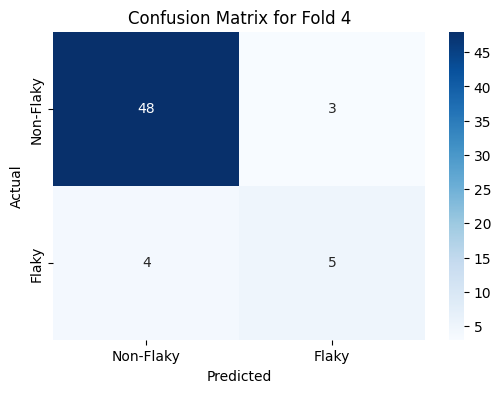

Fold 4: Accuracy=0.8833333333333333, Precision=0.8783653846153847, Recall=0.8833333333333333, F1=0.880468303826385, MCC=0.5217732845620352
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[51  0]
 [ 3  6]]


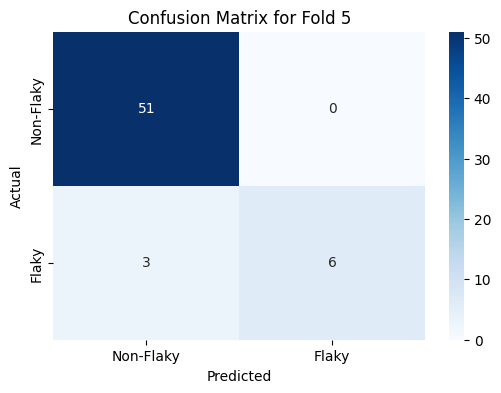

Fold 5: Accuracy=0.95, Precision=0.9527777777777777, Recall=0.95, F1=0.9457142857142858, MCC=0.7934920476158722
Average Accuracy: 0.9134972677595629
Average Precision: 0.9104999302674945
Average Recall: 0.9134972677595629
Average F1: 0.9083460172418653
Average MCC: 0.6442117186812651
SVM analysis completed for 5-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_svm-svm-results-5-folds.csv

Final Average Metrics for 3-fold SVM:
Accuracy: 0.9003300330033004
Precision: 0.8940160429674281
Recall: 0.9003300330033004
F1 Score: 0.8918502102199609
MCC: 0.578060766466176

Final Average Metrics for 5-fold SVM:
Accuracy: 0.9134972677595629
Precision: 0.9104999302674945
Recall: 0.9134972677595629
F1 Score: 0.9083460172418653
MCC: 0.6442117186812651


In [19]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty or invalid file skipped: {file_path}")

    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")

    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Step 1: Run GridSearchCV without SMOTE to find the best parameters for SVM

def find_best_params_without_smote(Z, dataLabelsList, n_splits):
    svm = SVC()

    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization parameter
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernel types
    }

    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=1),
        'recall': make_scorer(recall_score, average='weighted', zero_division=1),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=1)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(svm, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV on the original data without SMOTE
    grid_search.fit(Z, dataLabelsList)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters without SMOTE: {best_params}")
    print(f"Best F1 Score without SMOTE: {best_score}")

    return best_params

###############################################################################
# Step 2: Apply SMOTE only to the training data and run GridSearchCV with the best parameters for SVM

def flastSVMWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label, best_params):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")

    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_list, precision_list, recall_list, f1_list, mcc_list = [], [], [], [], []

    # Apply SMOTE and SVM with best parameters for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z, dataLabelsList), start=1):
        X_train, X_val = Z[train_idx], Z[val_idx]
        y_train, y_val = dataLabelsList[train_idx], dataLabelsList[val_idx]

        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        smote = SMOTE(random_state=42)
        # Apply SMOTE to the training data only
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Define the SVM model with best parameters
        svm = SVC(C=best_params['C'], kernel=best_params['kernel'])

        # Train the model and make predictions on the validation set
        svm.fit(X_resampled, y_resampled)
        y_pred = svm.predict(X_val)

        # Compute metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=1)
        mcc = matthews_corrcoef(y_val, y_pred)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)

        # Plot confusion matrix for the current fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)

        print(f"Fold {fold_idx}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1={f1}, MCC={mcc}")

    # Calculate average scores over all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    avg_mcc = np.mean(mcc_list)

    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1: {avg_f1}")
    print(f"Average MCC: {avg_mcc}")

    # Save the results to a CSV file
    outFile = os.path.join(outDir, f"{combination_label}-svm-results-{n_splits}-folds.csv")
    with open(outFile, "w") as f:
        f.write("Fold,Accuracy,Precision,Recall,F1,MCC\n")
        for idx, (acc, prec, rec, f1_score_val, mcc_val) in enumerate(zip(accuracy_list, precision_list, recall_list, f1_list, mcc_list), start=1):
            f.write(f"{idx},{acc},{prec},{rec},{f1_score_val},{mcc_val}\n")
        # Write the average metrics as the last row
        f.write(f"Average,{avg_accuracy},{avg_precision},{avg_recall},{avg_f1},{avg_mcc}\n")

    print(f"SVM analysis completed for {n_splits}-folds with SMOTE. Results saved to: {outFile}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_mcc

###############################################################################
# Main Function to Run Both 3-Fold and 5-Fold SMOTE for SVM

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "cleaned_flaky_files.zip"
    largerNonFlakyZip = "all_nonflaky_files.zip"

    outDirLarger = "smote2-results/larger_nonflaky"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote2-extracted/larger_nonflaky"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Step 1: Extract zip files into correct directories
    print("Extracting files...")
    flakyDir = os.path.join(extractDirLarger, 'flaky')
    nonFlakyDir = os.path.join(extractDirLarger, 'nonFlaky')

    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(largerNonFlakyZip, nonFlakyDir)

    # Step 2: Vectorization
    print("Starting Vectorization and SVM analysis...")
    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    if len(dataPoints) == 0:
        raise ValueError("No documents found for vectorization. Please check the input files or directories.")

    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))

    # Step 3: Run GridSearchCV without SMOTE to find the best SVM parameters
    best_params = find_best_params_without_smote(Z, dataLabelsList, n_splits=5)

    # Step 4: Apply SMOTE for both 3-Fold and 5-Fold Cross-Validation with SVM

    print("Starting SVM analysis with SMOTE for 3-fold cross-validation...")
    avg_accuracy_3folds, avg_precision_3folds, avg_recall_3folds, avg_f1_3folds, avg_mcc_3folds = flastSVMWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger_svm", best_params)

    print("Starting SVM analysis with SMOTE for 5-fold cross-validation...")
    avg_accuracy_5folds, avg_precision_5folds, avg_recall_5folds, avg_f1_5folds, avg_mcc_5folds = flastSVMWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger_svm", best_params)

    # Print Final Metrics for 3-fold and 5-fold
    print(f"\nFinal Average Metrics for 3-fold SVM:\nAccuracy: {avg_accuracy_3folds}\nPrecision: {avg_precision_3folds}\nRecall: {avg_recall_3folds}\nF1 Score: {avg_f1_3folds}\nMCC: {avg_mcc_3folds}")
    print(f"\nFinal Average Metrics for 5-fold SVM:\nAccuracy: {avg_accuracy_5folds}\nPrecision: {avg_precision_5folds}\nRecall: {avg_recall_5folds}\nF1 Score: {avg_f1_5folds}\nMCC: {avg_mcc_5folds}")


Naive Bayes

Extracting files...
Starting Vectorization and Naive Bayes analysis...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Naive Bayes: {'alpha': 0.001}
Best F1 Score for Naive Bayes: 0.9331516775557847
Starting Naive Bayes analysis with SMOTE for 3-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [169  31]
Validation class distribution: [85 16]
[[80  5]
 [ 9  7]]


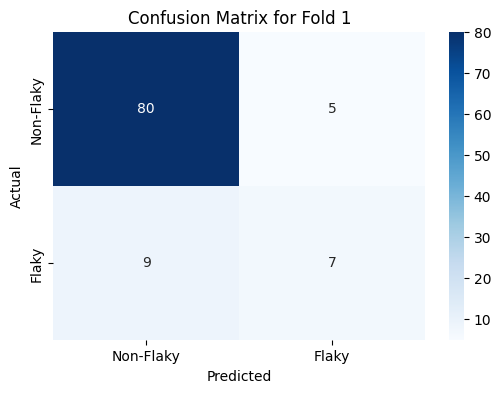

Fold 1: Accuracy=0.8613861386138614, Precision=0.8488893833203544, Recall=0.8613861386138614, F1=0.8530784112894048, MCC=0.4273189459921915
Training class distribution: [170  31]
Validation class distribution: [84 16]
[[83  1]
 [ 7  9]]


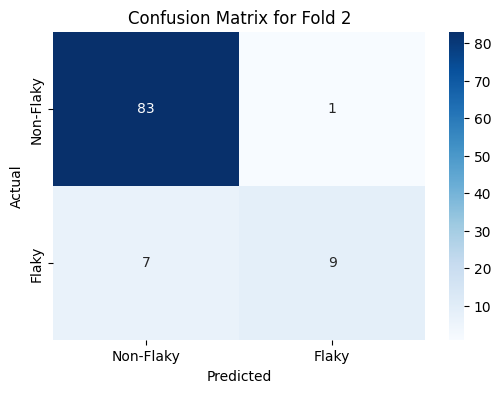

Fold 2: Accuracy=0.92, Precision=0.9186666666666667, Recall=0.92, F1=0.9121485411140583, MCC=0.6728384948943098
Training class distribution: [169  32]
Validation class distribution: [85 15]
[[85  0]
 [ 6  9]]


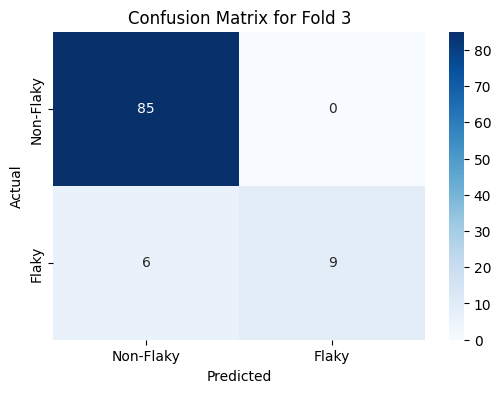

Fold 3: Accuracy=0.94, Precision=0.9439560439560439, Recall=0.94, F1=0.9335227272727273, MCC=0.7486251134176307
Average Accuracy: 0.9071287128712872
Average Precision: 0.9038373646476883
Average Recall: 0.9071287128712872
Average F1: 0.8995832265587301
Average MCC: 0.6162608514347107
Naive Bayes analysis completed for 3-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_naive_bayes-naive-bayes-results-3-folds.csv
Starting Naive Bayes analysis with SMOTE for 5-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [203  37]
Validation class distribution: [51 10]
[[51  0]
 [ 4  6]]


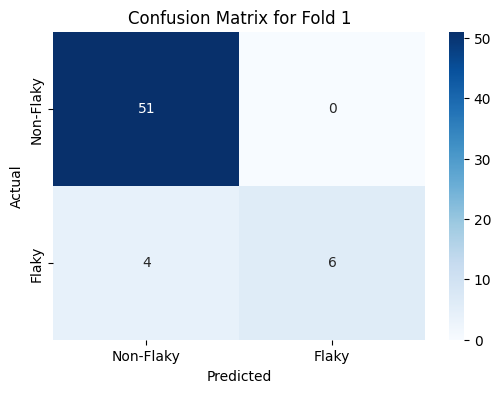

Fold 1: Accuracy=0.9344262295081968, Precision=0.9391952309985097, Recall=0.9344262295081968, F1=0.9274667491493968, MCC=0.7458978726096732
Training class distribution: [204  37]
Validation class distribution: [50 10]
[[44  6]
 [ 3  7]]


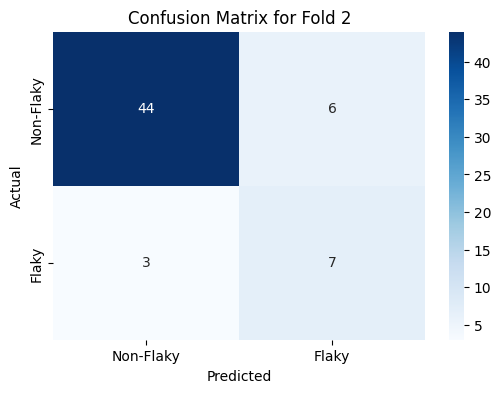

Fold 2: Accuracy=0.85, Precision=0.869885433715221, Recall=0.85, F1=0.8574630210667863, MCC=0.5246774396826565
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[50  1]
 [ 5  4]]


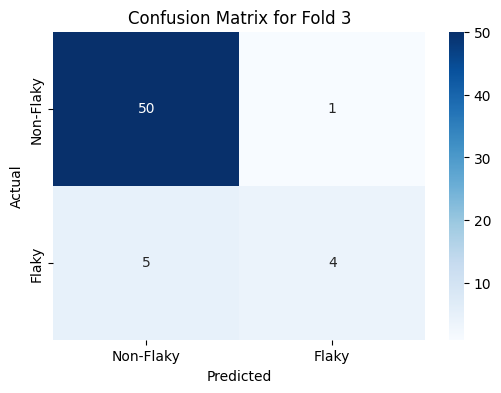

Fold 3: Accuracy=0.9, Precision=0.8927272727272727, Recall=0.9, F1=0.887601078167116, MCC=0.5488604301969738
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[50  1]
 [ 3  6]]


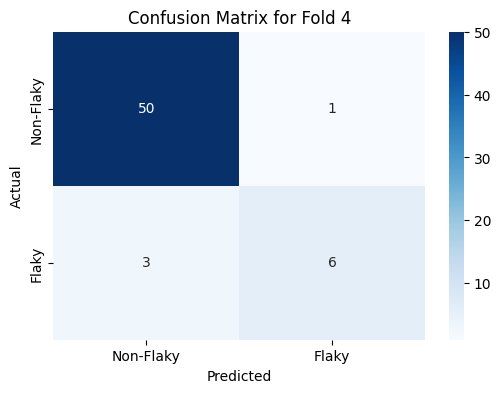

Fold 4: Accuracy=0.9333333333333333, Precision=0.9304582210242588, Recall=0.9333333333333333, F1=0.9298076923076923, MCC=0.7197193047267257
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[51  0]
 [ 2  7]]


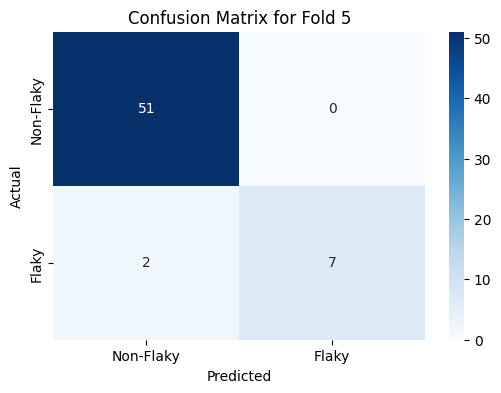

Fold 5: Accuracy=0.9666666666666667, Precision=0.9679245283018868, Recall=0.9666666666666667, F1=0.9649038461538461, MCC=0.8651171440654583
Average Accuracy: 0.9168852459016394
Average Precision: 0.9200381373534297
Average Recall: 0.9168852459016394
Average F1: 0.9134484773689675
Average MCC: 0.6808544382562975
Naive Bayes analysis completed for 5-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_naive_bayes-naive-bayes-results-5-folds.csv

Final Average Metrics for 3-fold Naive Bayes:
Accuracy: 0.9071287128712872
Precision: 0.9038373646476883
Recall: 0.9071287128712872
F1 Score: 0.8995832265587301
MCC: 0.6162608514347107

Final Average Metrics for 5-fold Naive Bayes:
Accuracy: 0.9168852459016394
Precision: 0.9200381373534297
Recall: 0.9168852459016394
F1 Score: 0.9134484773689675
MCC: 0.6808544382562975


In [22]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty or invalid file skipped: {file_path}")

    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")

    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Step 1: Run GridSearchCV for Naive Bayes to find the best `alpha` parameter

def find_best_params_for_naive_bayes(Z, dataLabelsList, n_splits):
    nb = MultinomialNB()

    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]  # Smoothing parameter
    }

    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=1),
        'recall': make_scorer(recall_score, average='weighted', zero_division=1),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=1)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(nb, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV
    grid_search.fit(Z, dataLabelsList)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters for Naive Bayes: {best_params}")
    print(f"Best F1 Score for Naive Bayes: {best_score}")

    return best_params

###############################################################################
# Step 2: Apply SMOTE only to the training data and evaluate Naive Bayes

def flastNaiveBayesWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label, best_params):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")

    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_list, precision_list, recall_list, f1_list, mcc_list = [], [], [], [], []

    # Apply SMOTE and Naive Bayes with best parameters for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z, dataLabelsList), start=1):
        X_train, X_val = Z[train_idx], Z[val_idx]
        y_train, y_val = dataLabelsList[train_idx], dataLabelsList[val_idx]

        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        smote = SMOTE(random_state=42)
        # Apply SMOTE to the training data only
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Train the Naive Bayes model with the best `alpha` parameter
        nb = MultinomialNB(alpha=best_params['alpha'])
        nb.fit(X_resampled, y_resampled)
        y_pred = nb.predict(X_val)

        # Compute metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=1)
        mcc = matthews_corrcoef(y_val, y_pred)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)

        # Plot confusion matrix for the current fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)

        print(f"Fold {fold_idx}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1={f1}, MCC={mcc}")

    # Calculate average scores over all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    avg_mcc = np.mean(mcc_list)

    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1: {avg_f1}")
    print(f"Average MCC: {avg_mcc}")

    # Save the results to a CSV file
    outFile = os.path.join(outDir, f"{combination_label}-naive-bayes-results-{n_splits}-folds.csv")
    with open(outFile, "w") as f:
        f.write("Fold,Accuracy,Precision,Recall,F1,MCC\n")
        for idx, (acc, prec, rec, f1_score_val, mcc_val) in enumerate(zip(accuracy_list, precision_list, recall_list, f1_list, mcc_list), start=1):
            f.write(f"{idx},{acc},{prec},{rec},{f1_score_val},{mcc_val}\n")
        # Write the average metrics as the last row
        f.write(f"Average,{avg_accuracy},{avg_precision},{avg_recall},{avg_f1},{avg_mcc}\n")

    print(f"Naive Bayes analysis completed for {n_splits}-folds with SMOTE. Results saved to: {outFile}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_mcc

###############################################################################
# Main Function to Run Both 3-Fold and 5-Fold SMOTE for Naive Bayes

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "cleaned_flaky_files.zip"
    largerNonFlakyZip = "all_nonflaky_files.zip"

    outDirLarger = "smote2-results/larger_nonflaky"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote2-extracted/larger_nonflaky"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Step 1: Extract zip files into correct directories
    print("Extracting files...")
    flakyDir = os.path.join(extractDirLarger, 'flaky')
    nonFlakyDir = os.path.join(extractDirLarger, 'nonFlaky')

    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(largerNonFlakyZip, nonFlakyDir)

    # Step 2: Vectorization
    print("Starting Vectorization and Naive Bayes analysis...")
    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    if len(dataPoints) == 0:
        raise ValueError("No documents found for vectorization. Please check the input files or directories.")

    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))

    # Step 3: Run GridSearchCV for Naive Bayes to find the best `alpha` parameter
    best_params = find_best_params_for_naive_bayes(Z, dataLabelsList, n_splits=5)

    # Step 4: Apply SMOTE for both 3-Fold and 5-Fold Cross-Validation with Naive Bayes
    print("Starting Naive Bayes analysis with SMOTE for 3-fold cross-validation...")
    avg_accuracy_3folds, avg_precision_3folds, avg_recall_3folds, avg_f1_3folds, avg_mcc_3folds = flastNaiveBayesWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger_naive_bayes", best_params)

    print("Starting Naive Bayes analysis with SMOTE for 5-fold cross-validation...")
    avg_accuracy_5folds, avg_precision_5folds, avg_recall_5folds, avg_f1_5folds, avg_mcc_5folds = flastNaiveBayesWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger_naive_bayes", best_params)

    # Print Final Metrics for 3-fold and 5-fold
    print(f"\nFinal Average Metrics for 3-fold Naive Bayes:\nAccuracy: {avg_accuracy_3folds}\nPrecision: {avg_precision_3folds}\nRecall: {avg_recall_3folds}\nF1 Score: {avg_f1_3folds}\nMCC: {avg_mcc_3folds}")
    print(f"\nFinal Average Metrics for 5-fold Naive Bayes:\nAccuracy: {avg_accuracy_5folds}\nPrecision: {avg_precision_5folds}\nRecall: {avg_recall_5folds}\nF1 Score: {avg_f1_5folds}\nMCC: {avg_mcc_5folds}")


Decision Tree

Extracting files...
Starting Vectorization and Decision Tree analysis...
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best F1 Score for Decision Tree: 0.9557379873883791
Starting Decision Tree analysis with SMOTE for 3-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [169  31]
Validation class distribution: [85 16]
[[84  1]
 [ 4 12]]


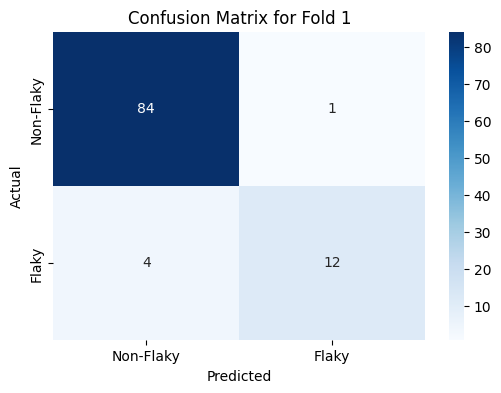

Fold 1: Accuracy=0.9504950495049505, Precision=0.9495603406494496, Recall=0.9504950495049505, F1=0.9483636822920881, MCC=0.8049172715678827
Training class distribution: [170  31]
Validation class distribution: [84 16]
[[80  4]
 [ 5 11]]


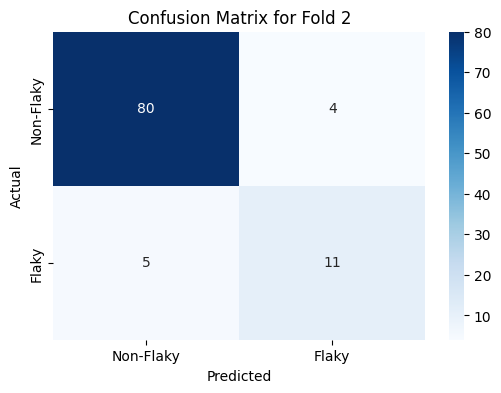

Fold 2: Accuracy=0.91, Precision=0.907921568627451, Recall=0.91, F1=0.9088146592861233, MCC=0.6569672562035515
Training class distribution: [169  32]
Validation class distribution: [85 15]
[[84  1]
 [ 1 14]]


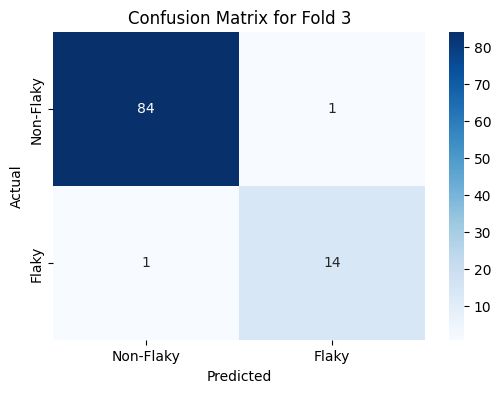

Fold 3: Accuracy=0.98, Precision=0.98, Recall=0.98, F1=0.98, MCC=0.9215686274509803
Average Accuracy: 0.9468316831683169
Average Precision: 0.9458273030923001
Average Recall: 0.9468316831683169
Average F1: 0.9457261138594037
Average MCC: 0.7944843850741381
Decision Tree analysis completed for 3-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_decision_tree-decision-tree-results-3-folds.csv
Starting Decision Tree analysis with SMOTE for 5-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [203  37]
Validation class distribution: [51 10]
[[50  1]
 [ 2  8]]


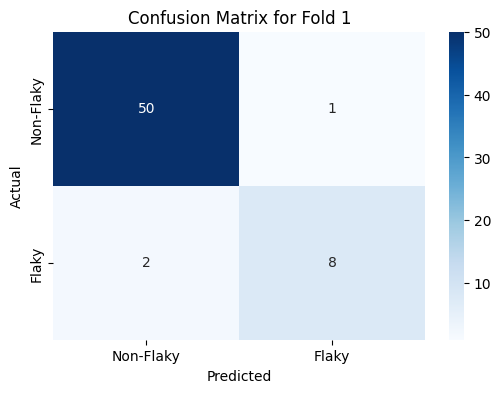

Fold 1: Accuracy=0.9508196721311475, Precision=0.949628695530335, Recall=0.9508196721311475, F1=0.9497641924323781, MCC=0.8146574950585488
Training class distribution: [204  37]
Validation class distribution: [50 10]
[[49  1]
 [ 3  7]]


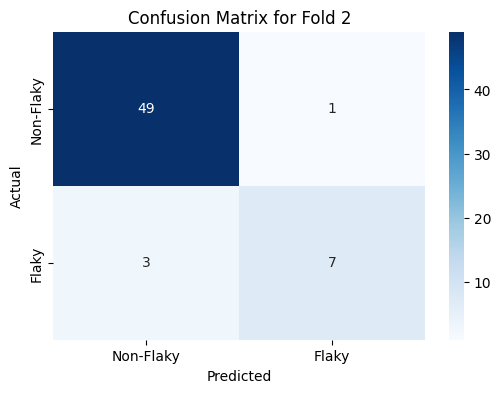

Fold 2: Accuracy=0.9333333333333333, Precision=0.9310897435897435, Recall=0.9333333333333333, F1=0.9302832244008715, MCC=0.7454993164109749
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[48  3]
 [ 0  9]]


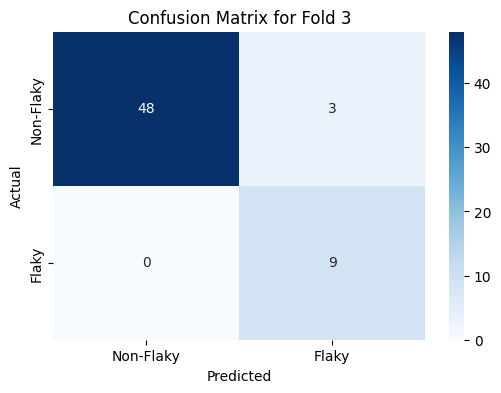

Fold 3: Accuracy=0.95, Precision=0.9625, Recall=0.95, F1=0.9528138528138528, MCC=0.8401680504168058
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[47  4]
 [ 2  7]]


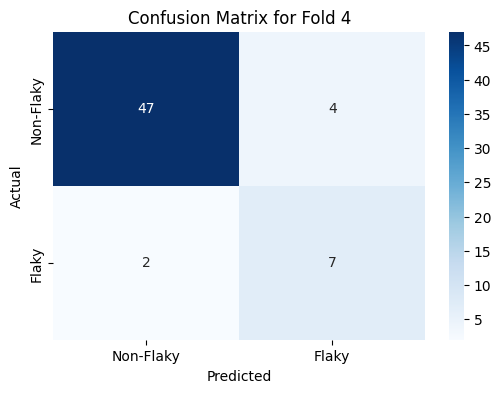

Fold 4: Accuracy=0.9, Precision=0.910760667903525, Recall=0.9, F1=0.9039999999999999, MCC=0.6453633629788592
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[50  1]
 [ 1  8]]


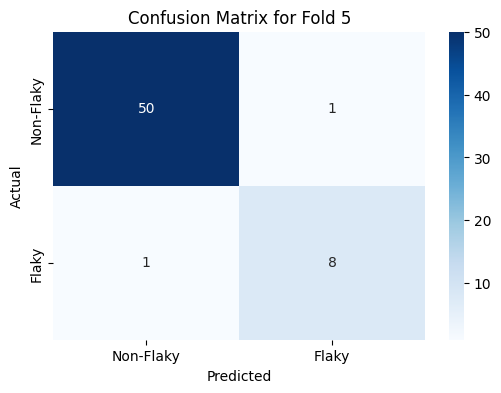

Fold 5: Accuracy=0.9666666666666667, Precision=0.9666666666666667, Recall=0.9666666666666667, F1=0.9666666666666667, MCC=0.869281045751634
Average Accuracy: 0.9401639344262295
Average Precision: 0.944129154738054
Average Recall: 0.9401639344262295
Average F1: 0.9407055872627538
Average MCC: 0.7829938541233645
Decision Tree analysis completed for 5-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_decision_tree-decision-tree-results-5-folds.csv

Final Average Metrics for 3-fold Decision Tree:
Accuracy: 0.9468316831683169
Precision: 0.9458273030923001
Recall: 0.9468316831683169
F1 Score: 0.9457261138594037
MCC: 0.7944843850741381

Final Average Metrics for 5-fold Decision Tree:
Accuracy: 0.9401639344262295
Precision: 0.944129154738054
Recall: 0.9401639344262295
F1 Score: 0.9407055872627538
MCC: 0.7829938541233645


In [23]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty or invalid file skipped: {file_path}")

    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")

    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Step 1: Run GridSearchCV for Decision Tree to find the best parameters

def find_best_params_for_decision_tree(Z, dataLabelsList, n_splits):
    dt = DecisionTreeClassifier(random_state=42)

    param_grid = {
        'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
        'max_depth': [None, 10, 30, 50, 100, 300, 500],  # Maximum depth of each tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 5, 10],  # Minimum number of samples required to be at a leaf node
        'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    }

    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=1),
        'recall': make_scorer(recall_score, average='weighted', zero_division=1),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=1)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(dt, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV
    grid_search.fit(Z, dataLabelsList)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters for Decision Tree: {best_params}")
    print(f"Best F1 Score for Decision Tree: {best_score}")

    return best_params

###############################################################################
# Step 2: Apply SMOTE only to the training data and evaluate Decision Tree

def flastDecisionTreeWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label, best_params):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")

    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_list, precision_list, recall_list, f1_list, mcc_list = [], [], [], [], []

    # Apply SMOTE and Decision Tree with best parameters for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z, dataLabelsList), start=1):
        X_train, X_val = Z[train_idx], Z[val_idx]
        y_train, y_val = dataLabelsList[train_idx], dataLabelsList[val_idx]

        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        smote = SMOTE(random_state=42)
        # Apply SMOTE to the training data only
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Train the Decision Tree model with the best parameters
        dt = DecisionTreeClassifier(**best_params, random_state=42)
        dt.fit(X_resampled, y_resampled)
        y_pred = dt.predict(X_val)

        # Compute metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=1)
        mcc = matthews_corrcoef(y_val, y_pred)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)

        # Plot confusion matrix for the current fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)

        print(f"Fold {fold_idx}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1={f1}, MCC={mcc}")

    # Calculate average scores over all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    avg_mcc = np.mean(mcc_list)

    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1: {avg_f1}")
    print(f"Average MCC: {avg_mcc}")

    # Save the results to a CSV file
    outFile = os.path.join(outDir, f"{combination_label}-decision-tree-results-{n_splits}-folds.csv")
    with open(outFile, "w") as f:
        f.write("Fold,Accuracy,Precision,Recall,F1,MCC\n")
        for idx, (acc, prec, rec, f1_score_val, mcc_val) in enumerate(zip(accuracy_list, precision_list, recall_list, f1_list, mcc_list), start=1):
            f.write(f"{idx},{acc},{prec},{rec},{f1_score_val},{mcc_val}\n")
        # Write the average metrics as the last row
        f.write(f"Average,{avg_accuracy},{avg_precision},{avg_recall},{avg_f1},{avg_mcc}\n")

    print(f"Decision Tree analysis completed for {n_splits}-folds with SMOTE. Results saved to: {outFile}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_mcc

###############################################################################
# Main Function to Run Both 3-Fold and 5-Fold SMOTE for Decision Tree

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "cleaned_flaky_files.zip"
    largerNonFlakyZip = "all_nonflaky_files.zip"

    outDirLarger = "smote2-results/larger_nonflaky"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote2-extracted/larger_nonflaky/"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Step 1: Extract zip files into correct directories
    print("Extracting files...")
    flakyDir = os.path.join(extractDirLarger, 'flaky')
    nonFlakyDir = os.path.join(extractDirLarger, 'nonFlaky')

    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(largerNonFlakyZip, nonFlakyDir)

    # Step 2: Vectorization
    print("Starting Vectorization and Decision Tree analysis...")
    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    if len(dataPoints) == 0:
        raise ValueError("No documents found for vectorization. Please check the input files or directories.")

    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))

    # Step 3: Run GridSearchCV for Decision Tree to find the best parameters
    best_params = find_best_params_for_decision_tree(Z, dataLabelsList, n_splits=5)

    # Step 4: Apply SMOTE for both 3-Fold and 5-Fold Cross-Validation with Decision Tree
    print("Starting Decision Tree analysis with SMOTE for 3-fold cross-validation...")
    avg_accuracy_3folds, avg_precision_3folds, avg_recall_3folds, avg_f1_3folds, avg_mcc_3folds = flastDecisionTreeWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger_decision_tree", best_params)

    print("Starting Decision Tree analysis with SMOTE for 5-fold cross-validation...")
    avg_accuracy_5folds, avg_precision_5folds, avg_recall_5folds, avg_f1_5folds, avg_mcc_5folds = flastDecisionTreeWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger_decision_tree", best_params)

    # Print Final Metrics for 3-fold and 5-fold
    print(f"\nFinal Average Metrics for 3-fold Decision Tree:\nAccuracy: {avg_accuracy_3folds}\nPrecision: {avg_precision_3folds}\nRecall: {avg_recall_3folds}\nF1 Score: {avg_f1_3folds}\nMCC: {avg_mcc_3folds}")
    print(f"\nFinal Average Metrics for 5-fold Decision Tree:\nAccuracy: {avg_accuracy_5folds}\nPrecision: {avg_precision_5folds}\nRecall: {avg_recall_5folds}\nF1 Score: {avg_f1_5folds}\nMCC: {avg_mcc_5folds}")


XGB

Extracting files...
Starting Vectorization and XGBoost analysis...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters for XGBoost: {'eta': 0.3, 'max_depth': 5, 'n_estimators': 50}
Best F1 Score for XGBoost: 0.9571940749482751
Starting XGBoost analysis with SMOTE for 3-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [169  31]
Validation class distribution: [85 16]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[85  0]
 [ 5 11]]


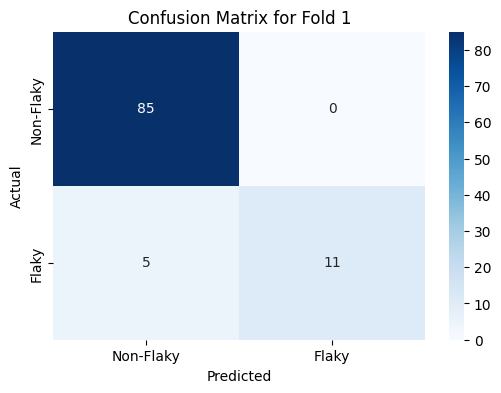

Fold 1: Accuracy=0.9504950495049505, Precision=0.9532453245324531, Recall=0.9504950495049505, F1=0.9466184713709466, MCC=0.8057949835755716
Training class distribution: [170  31]
Validation class distribution: [84 16]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[83  1]
 [ 3 13]]


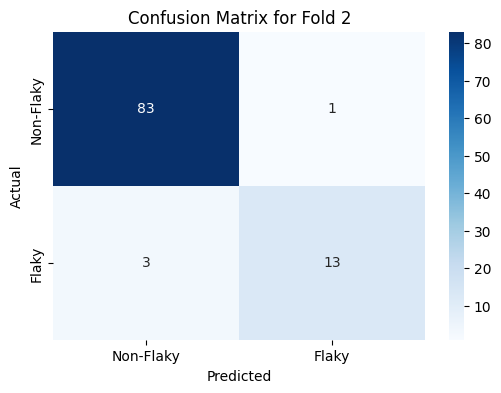

Fold 2: Accuracy=0.96, Precision=0.9592691029900332, Recall=0.96, F1=0.9589019607843136, MCC=0.8458617635771172
Training class distribution: [169  32]
Validation class distribution: [85 15]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[85  0]
 [ 1 14]]


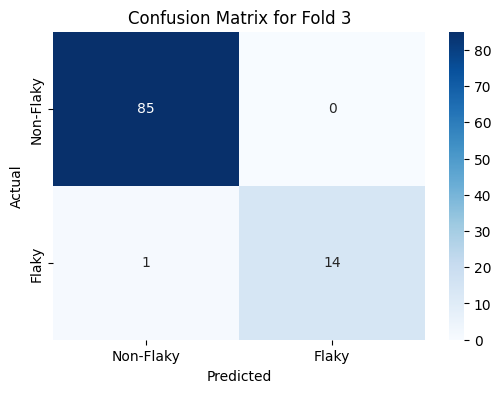

Fold 3: Accuracy=0.99, Precision=0.9901162790697674, Recall=0.99, F1=0.9898568259729784, MCC=0.9604585468176327
Average Accuracy: 0.9668316831683169
Average Precision: 0.9675435688640847
Average Recall: 0.9668316831683169
Average F1: 0.9651257527094129
Average MCC: 0.8707050979901071
XGBoost analysis completed for 3-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_xgb-xgb-results-3-folds.csv
Starting XGBoost analysis with SMOTE for 5-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [203  37]
Validation class distribution: [51 10]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[51  0]
 [ 5  5]]


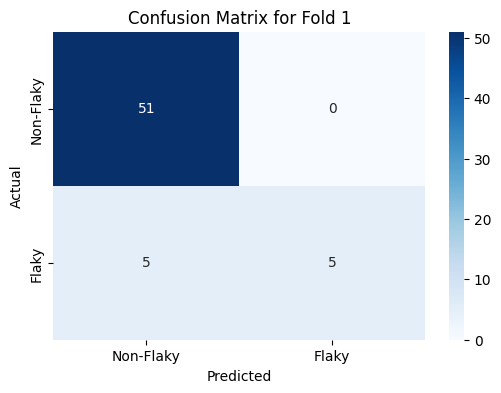

Fold 1: Accuracy=0.9180327868852459, Precision=0.925351288056206, Recall=0.9180327868852459, F1=0.9062867065012001, MCC=0.6748015581318281
Training class distribution: [204  37]
Validation class distribution: [50 10]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[50  0]
 [ 2  8]]


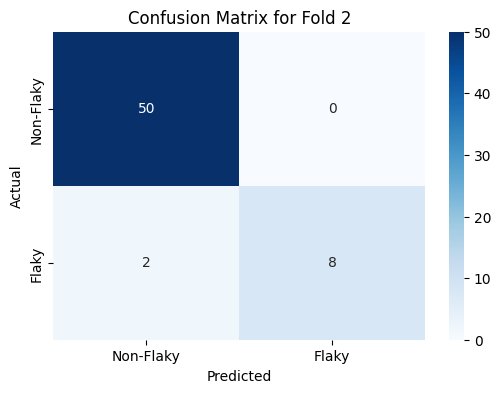

Fold 2: Accuracy=0.9666666666666667, Precision=0.967948717948718, Recall=0.9666666666666667, F1=0.9651416122004356, MCC=0.8770580193070292
Training class distribution: [203  38]
Validation class distribution: [51  9]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[51  0]
 [ 2  7]]


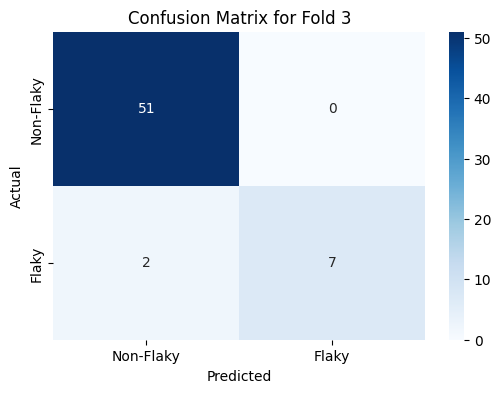

Fold 3: Accuracy=0.9666666666666667, Precision=0.9679245283018868, Recall=0.9666666666666667, F1=0.9649038461538461, MCC=0.8651171440654583
Training class distribution: [203  38]
Validation class distribution: [51  9]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[50  1]
 [ 1  8]]


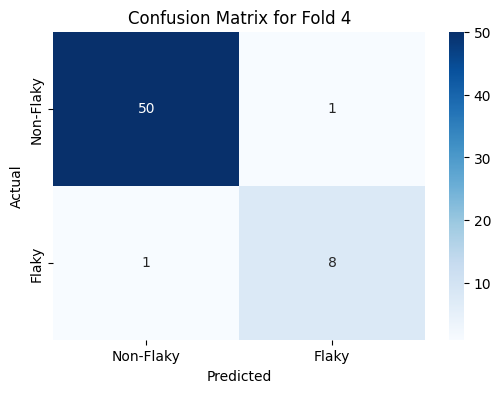

Fold 4: Accuracy=0.9666666666666667, Precision=0.9666666666666667, Recall=0.9666666666666667, F1=0.9666666666666667, MCC=0.869281045751634
Training class distribution: [203  38]
Validation class distribution: [51  9]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[51  0]
 [ 1  8]]


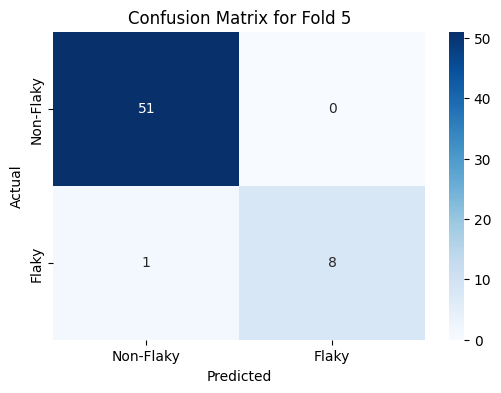

Fold 5: Accuracy=0.9833333333333333, Precision=0.9836538461538461, Recall=0.9833333333333333, F1=0.9829240434037693, MCC=0.9336995618478525
Average Accuracy: 0.9602732240437157
Average Precision: 0.9623090094254648
Average Recall: 0.9602732240437157
Average F1: 0.9571845749851835
Average MCC: 0.8439914658207603
XGBoost analysis completed for 5-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_xgb-xgb-results-5-folds.csv

Final Average Metrics for 3-fold XGBoost:
Accuracy: 0.9668316831683169
Precision: 0.9675435688640847
Recall: 0.9668316831683169
F1 Score: 0.9651257527094129
MCC: 0.8707050979901071

Final Average Metrics for 5-fold XGBoost:
Accuracy: 0.9602732240437157
Precision: 0.9623090094254648
Recall: 0.9602732240437157
F1 Score: 0.9571845749851835
MCC: 0.8439914658207603


In [29]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import (make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty or invalid file skipped: {file_path}")

    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")

    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    from sklearn.feature_extraction.text import CountVectorizer
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Step 1: Run GridSearchCV for XGBoost to find the best parameters (with MCC)

def find_best_params_for_xgb(Z, dataLabelsList, n_splits):
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)

    param_grid = {
        'eta': [0.01, 0.1, 0.3, 0.5],  # Learning rate
        'max_depth': [3, 5, 7, 10],  # Tree depth
        'n_estimators': [50, 100, 200, 300],  # Number of boosting rounds
    }

    # Custom scorer for MCC
    def mcc_scorer(y_true, y_pred):
        return matthews_corrcoef(y_true, y_pred)

    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=1),
        'recall': make_scorer(recall_score, average='weighted', zero_division=1),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=1),
        'mcc': make_scorer(mcc_scorer)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(xgb, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV
    grid_search.fit(Z, dataLabelsList)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters for XGBoost: {best_params}")
    print(f"Best F1 Score for XGBoost: {best_score}")

    return best_params

###############################################################################
# Step 2: Apply SMOTE only to the training data and evaluate XGBoost

def flastXGBoostWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label, best_params):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")

    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_list, precision_list, recall_list, f1_list, mcc_list = [], [], [], [], []

    # Apply SMOTE and XGBoost with best parameters for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z, dataLabelsList), start=1):
        X_train, X_val = Z[train_idx], Z[val_idx]
        y_train, y_val = dataLabelsList[train_idx], dataLabelsList[val_idx]

        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        smote = SMOTE(random_state=42)
        # Apply SMOTE to the training data only
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Train the XGBoost model with the best parameters
        xgb = XGBClassifier(
            max_depth=best_params['max_depth'],
            learning_rate=best_params['eta'],
            n_estimators=best_params['n_estimators'],
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )
        xgb.fit(X_resampled, y_resampled)
        y_pred = xgb.predict(X_val)

        # Compute metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=1)
        mcc = matthews_corrcoef(y_val, y_pred)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)

        # Plot confusion matrix for the current fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)

        print(f"Fold {fold_idx}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1={f1}, MCC={mcc}")

    # Calculate average scores over all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    avg_mcc = np.mean(mcc_list)

    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1: {avg_f1}")
    print(f"Average MCC: {avg_mcc}")

    # Save the results to a CSV file
    outFile = os.path.join(outDir, f"{combination_label}-xgb-results-{n_splits}-folds.csv")
    with open(outFile, "w") as f:
        f.write("Fold,Accuracy,Precision,Recall,F1,MCC\n")
        for idx, (acc, prec, rec, f1_score_val, mcc_val) in enumerate(zip(accuracy_list, precision_list, recall_list, f1_list, mcc_list), start=1):
            f.write(f"{idx},{acc},{prec},{rec},{f1_score_val},{mcc_val}\n")
        # Write the average metrics as the last row
        f.write(f"Average,{avg_accuracy},{avg_precision},{avg_recall},{avg_f1},{avg_mcc}\n")

    print(f"XGBoost analysis completed for {n_splits}-folds with SMOTE. Results saved to: {outFile}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_mcc

###############################################################################
# Main Function to Run Both 3-Fold and 5-Fold SMOTE for XGBoost

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "cleaned_flaky_files.zip"
    largerNonFlakyZip = "all_nonflaky_files.zip"

    outDirLarger = "smote2-results/larger_nonflaky"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote2-extracted/larger_nonflaky"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Step 1: Extract zip files into correct directories
    print("Extracting files...")
    flakyDir = os.path.join(extractDirLarger, 'flaky')
    nonFlakyDir = os.path.join(extractDirLarger, 'nonFlaky')

    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(largerNonFlakyZip, nonFlakyDir)

    # Step 2: Vectorization
    print("Starting Vectorization and XGBoost analysis...")
    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    if len(dataPoints) == 0:
        raise ValueError("No documents found for vectorization. Please check the input files or directories.")

    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))

    # Step 3: Run GridSearchCV for XGBoost to find the best parameters
    best_params = find_best_params_for_xgb(Z, dataLabelsList, n_splits=5)

    # Step 4: Apply SMOTE for both 3-Fold and 5-Fold Cross-Validation with XGBoost
    print("Starting XGBoost analysis with SMOTE for 3-fold cross-validation...")
    avg_accuracy_3folds, avg_precision_3folds, avg_recall_3folds, avg_f1_3folds, avg_mcc_3folds = flastXGBoostWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger_xgb", best_params)

    print("Starting XGBoost analysis with SMOTE for 5-fold cross-validation...")
    avg_accuracy_5folds, avg_precision_5folds, avg_recall_5folds, avg_f1_5folds, avg_mcc_5folds = flastXGBoostWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger_xgb", best_params)

    # Print Final Metrics for 3-fold and 5-fold
    print(f"\nFinal Average Metrics for 3-fold XGBoost:\nAccuracy: {avg_accuracy_3folds}\nPrecision: {avg_precision_3folds}\nRecall: {avg_recall_3folds}\nF1 Score: {avg_f1_3folds}\nMCC: {avg_mcc_3folds}")
    print(f"\nFinal Average Metrics for 5-fold XGBoost:\nAccuracy: {avg_accuracy_5folds}\nPrecision: {avg_precision_5folds}\nRecall: {avg_recall_5folds}\nF1 Score: {avg_f1_5folds}\nMCC: {avg_mcc_5folds}")


Random Forest

Extracting files...
Starting Vectorization and Random Forest analysis...
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 Score for Random Forest: 0.9529940987947073
Starting Random Forest analysis with SMOTE for 3-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [169  31]
Validation class distribution: [85 16]
[[77  8]
 [ 4 12]]


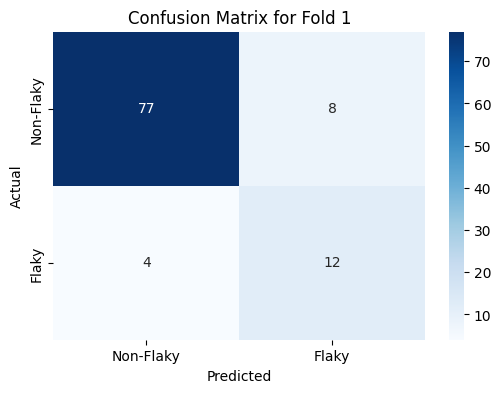

Fold 1: Accuracy=0.8811881188118812, Precision=0.8950739518396283, Recall=0.8811881188118812, F1=0.8863573104298382, MCC=0.6009493820344695
Training class distribution: [170  31]
Validation class distribution: [84 16]
[[81  3]
 [ 8  8]]


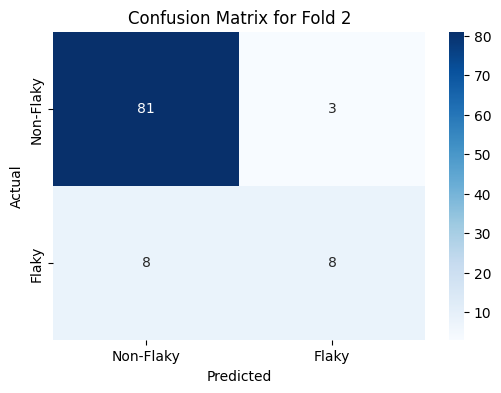

Fold 2: Accuracy=0.89, Precision=0.8808580183861083, Recall=0.89, F1=0.8814044101905374, MCC=0.5439933734070782
Training class distribution: [169  32]
Validation class distribution: [85 15]
[[84  1]
 [ 2 13]]


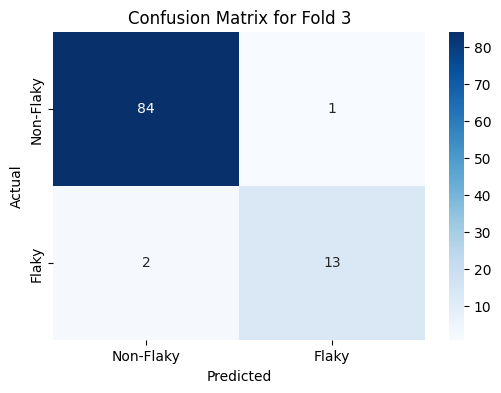

Fold 3: Accuracy=0.97, Precision=0.9695182724252491, Recall=0.97, F1=0.9695704779189352, MCC=0.87974774456405
Average Accuracy: 0.9137293729372938
Average Precision: 0.9151500808836618
Average Recall: 0.9137293729372938
Average F1: 0.9124440661797703
Average MCC: 0.6748968333351991
Random Forest analysis completed for 3-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_random_forest-random-forest-results-3-folds.csv
Starting Random Forest analysis with SMOTE for 5-fold cross-validation...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
Training class distribution: [203  37]
Validation class distribution: [51 10]
[[49  2]
 [ 4  6]]


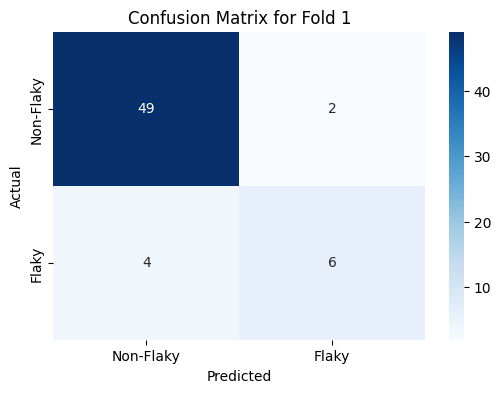

Fold 1: Accuracy=0.9016393442622951, Precision=0.8959171048561708, Recall=0.9016393442622951, F1=0.8971206389239176, MCC=0.6150324307400424
Training class distribution: [204  37]
Validation class distribution: [50 10]
[[48  2]
 [ 1  9]]


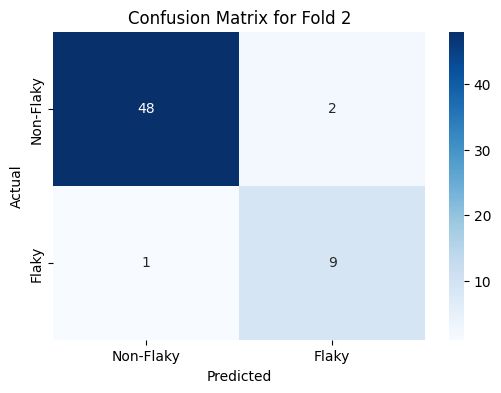

Fold 2: Accuracy=0.95, Precision=0.9526901669758812, Recall=0.95, F1=0.9509379509379509, MCC=0.828302688169126
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[50  1]
 [ 3  6]]


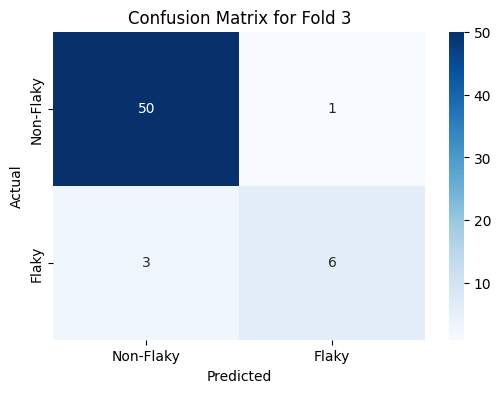

Fold 3: Accuracy=0.9333333333333333, Precision=0.9304582210242588, Recall=0.9333333333333333, F1=0.9298076923076923, MCC=0.7197193047267257
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[50  1]
 [ 2  7]]


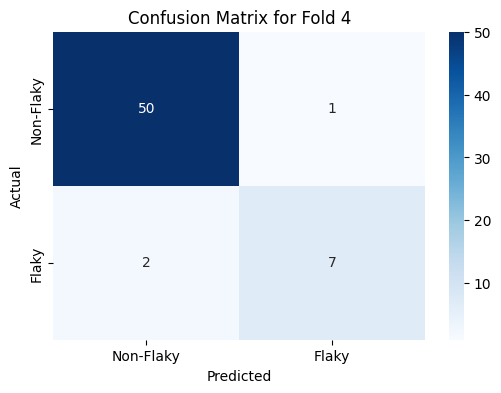

Fold 4: Accuracy=0.95, Precision=0.9485576923076924, Recall=0.95, F1=0.9487721302113079, MCC=0.79639080275258
Training class distribution: [203  38]
Validation class distribution: [51  9]
[[50  1]
 [ 1  8]]


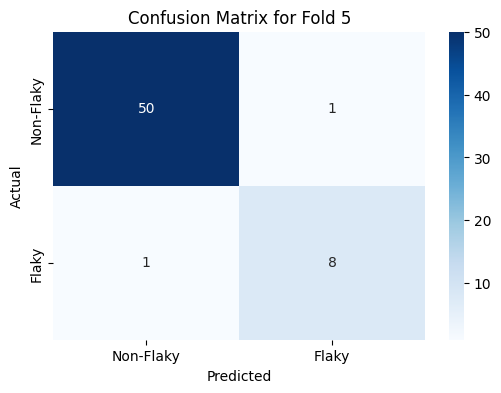

Fold 5: Accuracy=0.9666666666666667, Precision=0.9666666666666667, Recall=0.9666666666666667, F1=0.9666666666666667, MCC=0.869281045751634
Average Accuracy: 0.940327868852459
Average Precision: 0.9388579703661339
Average Recall: 0.940327868852459
Average F1: 0.938661015809507
Average MCC: 0.7657452544280217
Random Forest analysis completed for 5-folds with SMOTE. Results saved to: smote2-results/larger_nonflaky/larger_random_forest-random-forest-results-5-folds.csv

Final Average Metrics for 3-fold Random Forest:
Accuracy: 0.9137293729372938
Precision: 0.9151500808836618
Recall: 0.9137293729372938
F1 Score: 0.9124440661797703
MCC: 0.6748968333351991

Final Average Metrics for 5-fold Random Forest:
Accuracy: 0.940327868852459
Precision: 0.9388579703661339
Recall: 0.940327868852459
F1 Score: 0.938661015809507
MCC: 0.7657452544280217


In [28]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty or invalid file skipped: {file_path}")

    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")

    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    from sklearn.feature_extraction.text import CountVectorizer
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Step 1: Run GridSearchCV for Random Forest to find the best parameters

def find_best_params_for_rf(Z, dataLabelsList, n_splits):
    rf = RandomForestClassifier(random_state=42)

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [10, 50, 100, 300],  # Number of trees
        'max_depth': [10, 30, 50, 100, 300],  # Maximum depth of each tree
        'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
        "criterion": ["gini", "entropy"], # Function to measure the quality of a split
    }

    # Custom scorer for MCC
    def mcc_scorer(y_true, y_pred):
        return matthews_corrcoef(y_true, y_pred)

    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=1),
        'recall': make_scorer(recall_score, average='weighted', zero_division=1),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=1),
        'mcc': make_scorer(mcc_scorer)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(rf, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV
    grid_search.fit(Z, dataLabelsList)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters for Random Forest: {best_params}")
    print(f"Best F1 Score for Random Forest: {best_score}")

    return best_params

###############################################################################
# Step 2: Apply SMOTE only to the training data and evaluate Random Forest

def flastRandomForestWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label, best_params):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")

    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_list, precision_list, recall_list, f1_list, mcc_list = [], [], [], [], []

    # Apply SMOTE and Random Forest with best parameters for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z, dataLabelsList), start=1):
        X_train, X_val = Z[train_idx], Z[val_idx]
        y_train, y_val = dataLabelsList[train_idx], dataLabelsList[val_idx]

        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        smote = SMOTE(random_state=42)
        # Apply SMOTE to the training data only
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Train the Random Forest model with the best parameters
        rf = RandomForestClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        rf.fit(X_resampled, y_resampled)
        y_pred = rf.predict(X_val)

        # Compute metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=1)
        mcc = matthews_corrcoef(y_val, y_pred)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)

        # Plot confusion matrix for the current fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)

        print(f"Fold {fold_idx}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1={f1}, MCC={mcc}")

    # Calculate average scores over all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)
    avg_mcc = np.mean(mcc_list)

    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1: {avg_f1}")
    print(f"Average MCC: {avg_mcc}")

    # Save the results to a CSV file
    outFile = os.path.join(outDir, f"{combination_label}-random-forest-results-{n_splits}-folds.csv")
    with open(outFile, "w") as f:
        f.write("Fold,Accuracy,Precision,Recall,F1,MCC\n")
        for idx, (acc, prec, rec, f1_score_val, mcc_val) in enumerate(zip(accuracy_list, precision_list, recall_list, f1_list, mcc_list), start=1):
            f.write(f"{idx},{acc},{prec},{rec},{f1_score_val},{mcc_val}\n")
        # Write the average metrics as the last row
        f.write(f"Average,{avg_accuracy},{avg_precision},{avg_recall},{avg_f1},{avg_mcc}\n")

    print(f"Random Forest analysis completed for {n_splits}-folds with SMOTE. Results saved to: {outFile}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_mcc

###############################################################################
# Main Function to Run Both 3-Fold and 5-Fold SMOTE for Random Forest

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "cleaned_flaky_files.zip"
    largerNonFlakyZip = "all_nonflaky_files.zip"

    outDirLarger = "smote2-results/larger_nonflaky"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote2-extracted/larger_nonflaky"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Step 1: Extract zip files into correct directories
    print("Extracting files...")
    flakyDir = os.path.join(extractDirLarger, 'flaky')
    nonFlakyDir = os.path.join(extractDirLarger, 'nonFlaky')

    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    extract_zip(flakyZip, flakyDir)
    extract_zip(largerNonFlakyZip, nonFlakyDir)

    # Step 2: Vectorization
    print("Starting Vectorization and Random Forest analysis...")
    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    if len(dataPoints) == 0:
        raise ValueError("No documents found for vectorization. Please check the input files or directories.")

    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))

    # Step 3: Run GridSearchCV for Random Forest to find the best parameters (with MCC)
    best_params = find_best_params_for_rf(Z, dataLabelsList, n_splits=5)

    # Step 4: Apply SMOTE for both 3-Fold and 5-Fold Cross-Validation with Random Forest
    print("Starting Random Forest analysis with SMOTE for 3-fold cross-validation...")
    avg_accuracy_3folds, avg_precision_3folds, avg_recall_3folds, avg_f1_3folds, avg_mcc_3folds = flastRandomForestWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger_random_forest", best_params)

    print("Starting Random Forest analysis with SMOTE for 5-fold cross-validation...")
    avg_accuracy_5folds, avg_precision_5folds, avg_recall_5folds, avg_f1_5folds, avg_mcc_5folds = flastRandomForestWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger_random_forest", best_params)

    # Print Final Metrics for 3-fold and 5-fold
    print(f"\nFinal Average Metrics for 3-fold Random Forest:\nAccuracy: {avg_accuracy_3folds}\nPrecision: {avg_precision_3folds}\nRecall: {avg_recall_3folds}\nF1 Score: {avg_f1_3folds}\nMCC: {avg_mcc_3folds}")
    print(f"\nFinal Average Metrics for 5-fold Random Forest:\nAccuracy: {avg_accuracy_5folds}\nPrecision: {avg_precision_5folds}\nRecall: {avg_recall_5folds}\nF1 Score: {avg_f1_5folds}\nMCC: {avg_mcc_5folds}")


In [34]:
import os
import pandas as pd

# Function to extract the average results from the CSV files in the directory
def extract_average_results(csv_file):
    """
    Extracts the average result from a CSV file.

    Parameters:
    - csv_file: The path to the CSV file containing the model's results

    Returns:
    A dictionary containing the average results from the CSV file.
    """
    if not os.path.exists(csv_file):
        print(f"CSV file does not exist: {csv_file}")
        return None

    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Debug: Print the first few rows of the DataFrame
    print(f"Processing file: {csv_file}")
    print(df.head())  # Print the first few rows for inspection

    # Ensure the necessary columns are present
    required_columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'MCC']
    if not all(col in df.columns for col in required_columns):
        print(f"Missing one or more required columns ({', '.join(required_columns)}) in the file: {csv_file}")
        return None

    # Get the average values for the metrics
    avg_accuracy = df['Accuracy'].mean()
    avg_precision = df['Precision'].mean()
    avg_recall = df['Recall'].mean()
    avg_f1 = df['F1'].mean()
    avg_mcc = df['MCC'].mean()

    # Extract the file name without extension to use as the model name
    model_name = os.path.basename(csv_file).replace('.csv', '')

    # Collect the average results into a dictionary
    average_results = {
        'Model': model_name,
        'Average Accuracy': avg_accuracy,
        'Average Precision': avg_precision,
        'Average Recall': avg_recall,
        'Average F1 Score': avg_f1,
        'Average MCC': avg_mcc
    }

    return average_results

# Function to gather and print/save the average results from all CSV files in a folder
def gather_average_results_from_folder(results_dir, output_file):
    """
    Gathers the average results from all CSV files in a folder and writes them to a CSV file.

    Parameters:
    - results_dir: Directory where the result CSV files are stored.
    - output_file: Path to the output CSV file to store the average results.
    """
    # Get all CSV files in the results directory
    csv_files = [f for f in os.listdir(results_dir) if f.endswith('.csv')]

    # Debug: Print the CSV files found
    print(f"CSV files found: {csv_files}")

    # Initialize an empty list to store the average results from each CSV file
    average_results = []

    # Iterate over each CSV file in the directory
    for csv_file in csv_files:
        full_csv_path = os.path.join(results_dir, csv_file)
        avg_result = extract_average_results(full_csv_path)
        if avg_result:
            average_results.append(avg_result)

    if not average_results:
        print("No valid results found.")
        return

    # Convert the list of average results into a DataFrame
    average_results_df = pd.DataFrame(average_results)

    # Save the average results to the output CSV file
    average_results_df.to_csv(output_file, index=False)
    print(f"Average results saved to: {output_file}")

    # Print the average results as a table
    print(f"\nAverage Results from All CSV Files in the Folder:")
    print(average_results_df.to_string(index=False))

# Example usage
if __name__ == "__main__":
    # Directory where the result CSV files are stored
    results_dir = '/content/smote2-results/larger_nonflaky'

    # Path to the output CSV file where average results will be stored
    output_file = "average_results_from_smote_models.csv"

    # Gather and save the average results from all CSV files in the folder
    gather_average_results_from_folder(results_dir, output_file)


CSV files found: ['larger_svm-svm-results-5-folds.csv', 'larger_decision_tree-decision-tree-results-5-folds.csv', 'larger_xgb-xgb-results-3-folds.csv', 'larger_naive_bayes-naive-bayes-results-5-folds.csv', 'larger_random_forest-random-forest-results-5-folds.csv', 'larger_xgb-xgb-results-5-folds.csv', 'larger_svm-svm-results-3-folds.csv', 'larger-knn-results-3-folds.csv', 'larger_naive_bayes-naive-bayes-results-3-folds.csv', 'larger_decision_tree-decision-tree-results-3-folds.csv', 'larger_random_forest-random-forest-results-3-folds.csv', 'larger-knn-results-5-folds.csv']
Processing file: /content/smote2-results/larger_nonflaky/larger_svm-svm-results-5-folds.csv
  Fold  Accuracy  Precision    Recall        F1       MCC
0    1  0.950820   0.953552  0.950820  0.947183  0.813087
1    2  0.916667   0.920532  0.916667  0.918230  0.712726
2    3  0.866667   0.847273  0.866667  0.850135  0.379980
3    4  0.883333   0.878365  0.883333  0.880468  0.521773
4    5  0.950000   0.952778  0.950000  0